### 0.0. Dependencies

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

### 1.1. Model Assumptions

In [3]:
retail_areas = pd.read_csv("retail_areas_final.csv")

In [22]:
print(retail_areas.dtypes)

date                                                       object
id                                                          int64
events                                                      int64
weekend                                                      bool
season                                                     object
holiday                                                      bool
Local_Footprint_Centre_ID                                  object
Residential Population (Weighted Catchment)                 int64
Retail Footprint Score                                    float64
Base Score                                                float64
Tourism Score                                             float64
Convenience_Score                                         float64
Retail_Footprint_Comparison_Retailer_Score                float64
Leisure_Footprint_Score                                   float64
Auto_Score                                                float64
Local Foot

#### 1.1.1. Check for linear relationships

KeyboardInterrupt: 

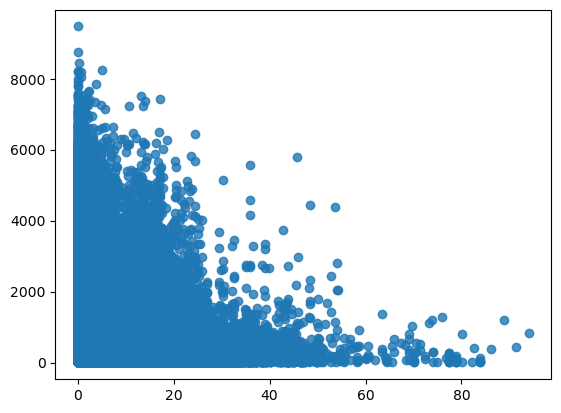

In [ ]:
weather_vars = ['rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust']

for var in weather_vars:
    sns.lmplot(x=var, y='events', data=retail_areas, line_kws={'color': 'red'})
    plt.title(f'Linear Relationship: {var} vs Events')
    plt.show() way to plot this so its not a straight line, but can take curved form?

#### 1.2. Random Forest

In [115]:
# Copy to avoid modifying original
df_model = retail_areas.copy()

# binary encode 'coastal'
df_model['coastal'] = df_model['coastal'].map({'coastal': 1, 'inland': 0})

# One-hot encode categorical variables
cat_vars = ['season', 'Sparsity', 'Region']
            #'supergroupName', 'groupName']
df_model = pd.get_dummies(df_model, columns=cat_vars, drop_first=True)

In [86]:
# Define features and target
features = ['rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust'] + \
           [col for col in df_model.columns if col.startswith('groupName_')]
target = 'events'  # or use another footfall measure if available

In [57]:
print(features)

['rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust', 'groupName_Indie high streets', 'groupName_Large regional retail and leisure destinations', 'groupName_Local urban convenience centres', 'groupName_Mass and value high streets', 'groupName_Primary shopping centres and premium destinations', 'groupName_Secondary retail parks and shopping centres', 'groupName_Sub-regional retail and leisure destinations']


In [59]:
# drop NaNs
df_model = df_model.dropna(subset=[target] + features + weather_vars)

In [ ]:
#### how many unique IDs per unique date?

Basic: Retail Types and Weather v. Footfall

In [61]:
X = df_model[features]
y = df_model[target]

# fit Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# predict and evaluate
y_pred = rf.predict(X)
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

# print model fit
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.2f}")

R²: 0.881
RMSE: 216.68


In [94]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Copy to avoid modifying original
df_model = retail_areas.copy()

group_col = 'groupName'
weather_vars = ['rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust']

for name, group_data in df_model.groupby(group_col):
    X = group_data[weather_vars]
    y = group_data['events']
    
    if len(X) > 30:  # skip small groups
        model = RandomForestRegressor(random_state=42).fit(X, y)
        r2 = model.score(X, y)
        
        # Compute feature importances
        importances = pd.Series(model.feature_importances_, index=weather_vars).sort_values(ascending=False)

        print(f"\n{name}: R² = {r2:.3f}")
        print("Feature Importances:")
        print(importances.round(3))


District urban service centres: R² = 0.818
Feature Importances:
tasmax       0.240
tasmin       0.213
mean_wind    0.189
max_gust     0.184
rainfall     0.174
dtype: float64

Indie high streets: R² = 0.802
Feature Importances:
tasmax       0.222
tasmin       0.216
mean_wind    0.199
max_gust     0.194
rainfall     0.169
dtype: float64

Large regional retail and leisure destinations: R² = 0.728
Feature Importances:
mean_wind    0.287
max_gust     0.282
tasmin       0.154
tasmax       0.153
rainfall     0.123
dtype: float64

Local urban convenience centres: R² = 0.797
Feature Importances:
mean_wind    0.228
max_gust     0.207
tasmin       0.204
tasmax       0.201
rainfall     0.160
dtype: float64

Mass and value high streets: R² = 0.829
Feature Importances:
tasmax       0.252
tasmin       0.234
rainfall     0.177
max_gust     0.168
mean_wind    0.167
dtype: float64

Primary shopping centres and premium destinations: R² = 0.868
Feature Importances:
tasmax       0.234
tasmin       0.205
m

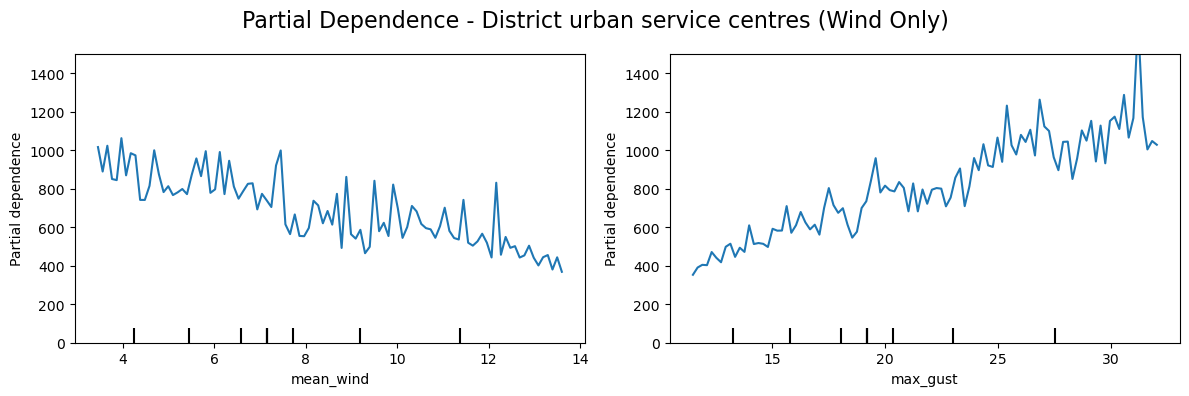

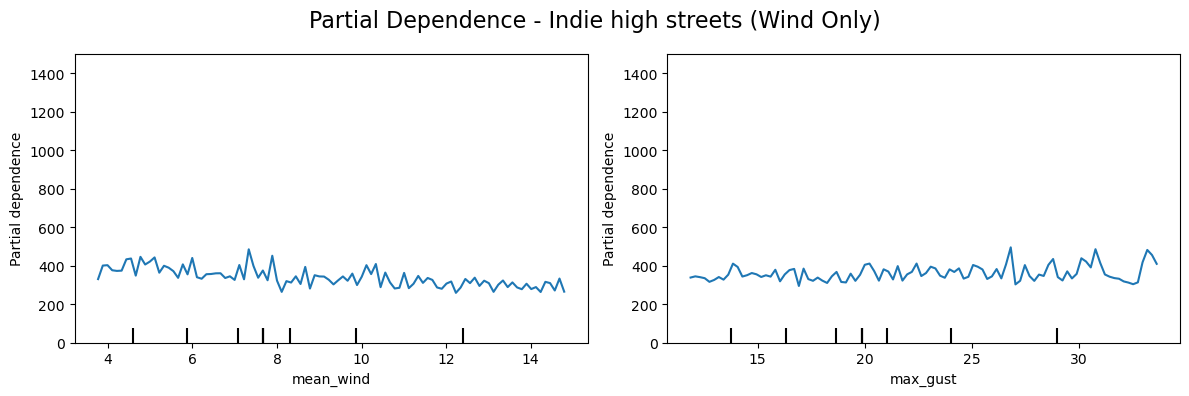

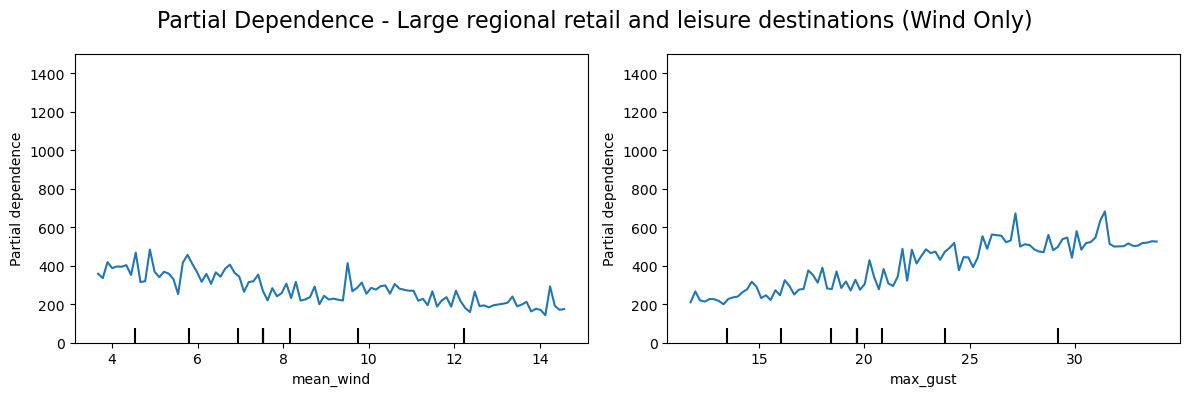

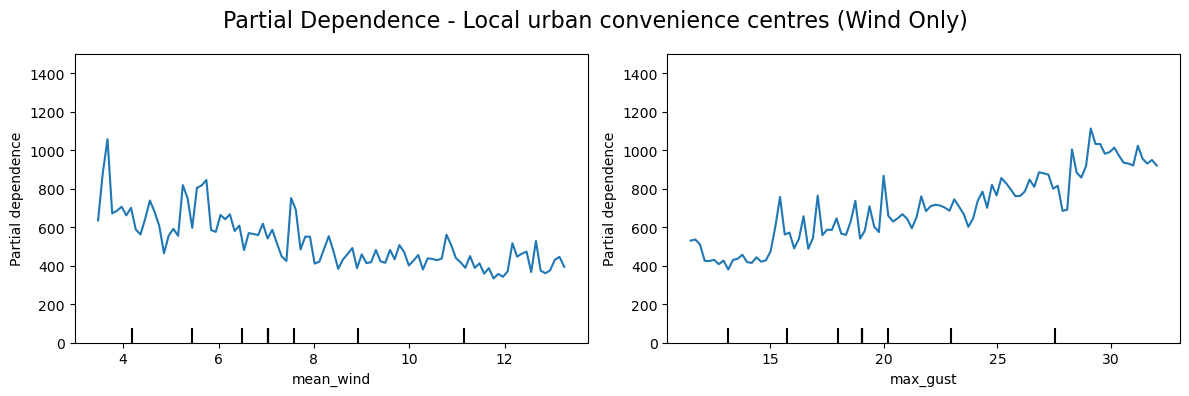

KeyboardInterrupt: 

In [101]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

for name, group_data in df_model.groupby('groupName'):
    X = group_data[['mean_wind', 'max_gust']].copy()
    y = group_data['events']
    
    # Fill NaNs just in case
    X = X.fillna(X.median())
    
    model = RandomForestRegressor().fit(X, y)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    display = PartialDependenceDisplay.from_estimator(
        model,
        X,
        features=['mean_wind', 'max_gust'],
        ax=ax
    )
    
    for axis in ax:
        axis.set_ylim(0, 1500)
    
    plt.suptitle(f'Partial Dependence - {name} (Wind Only)', fontsize=16)
    plt.tight_layout()
    plt.show()


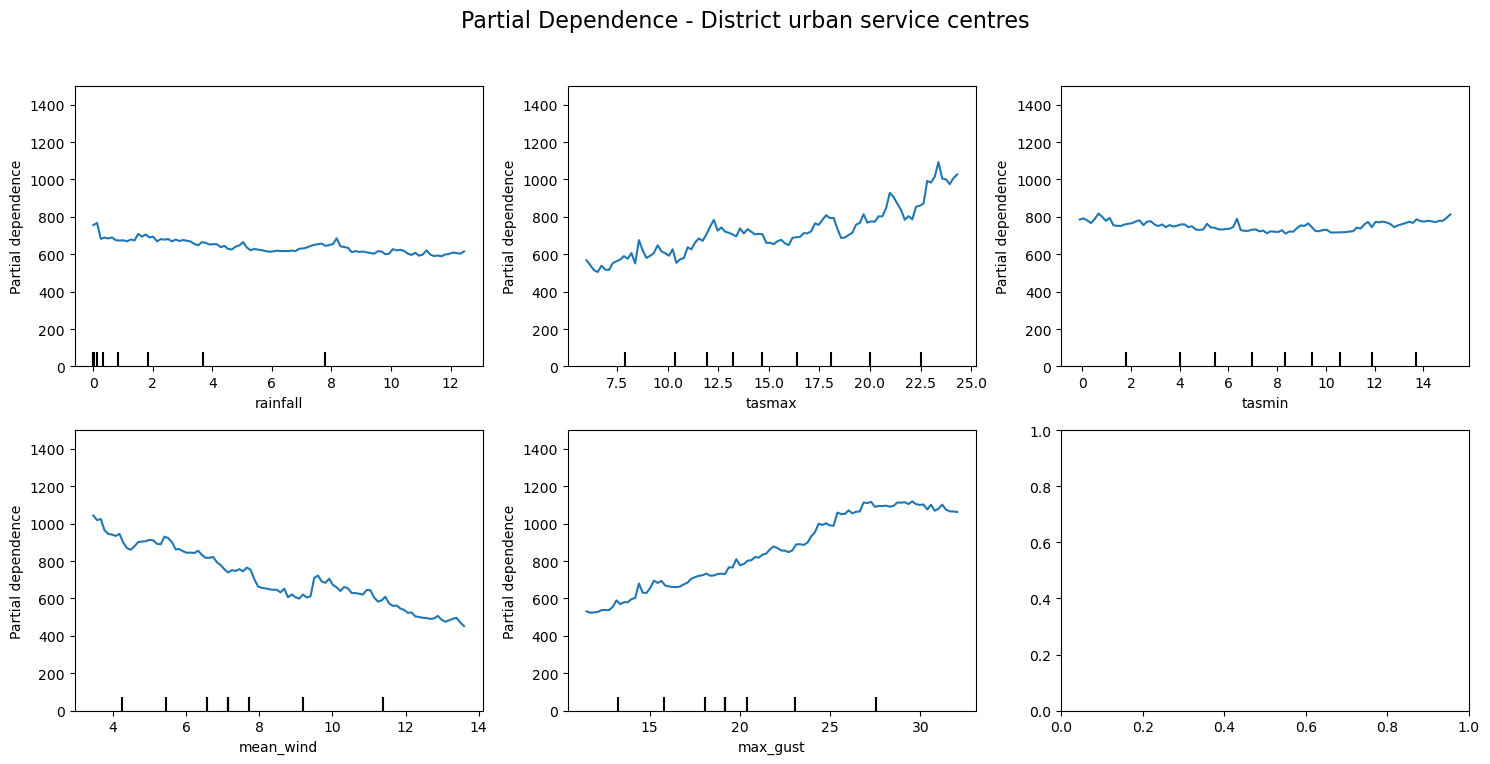

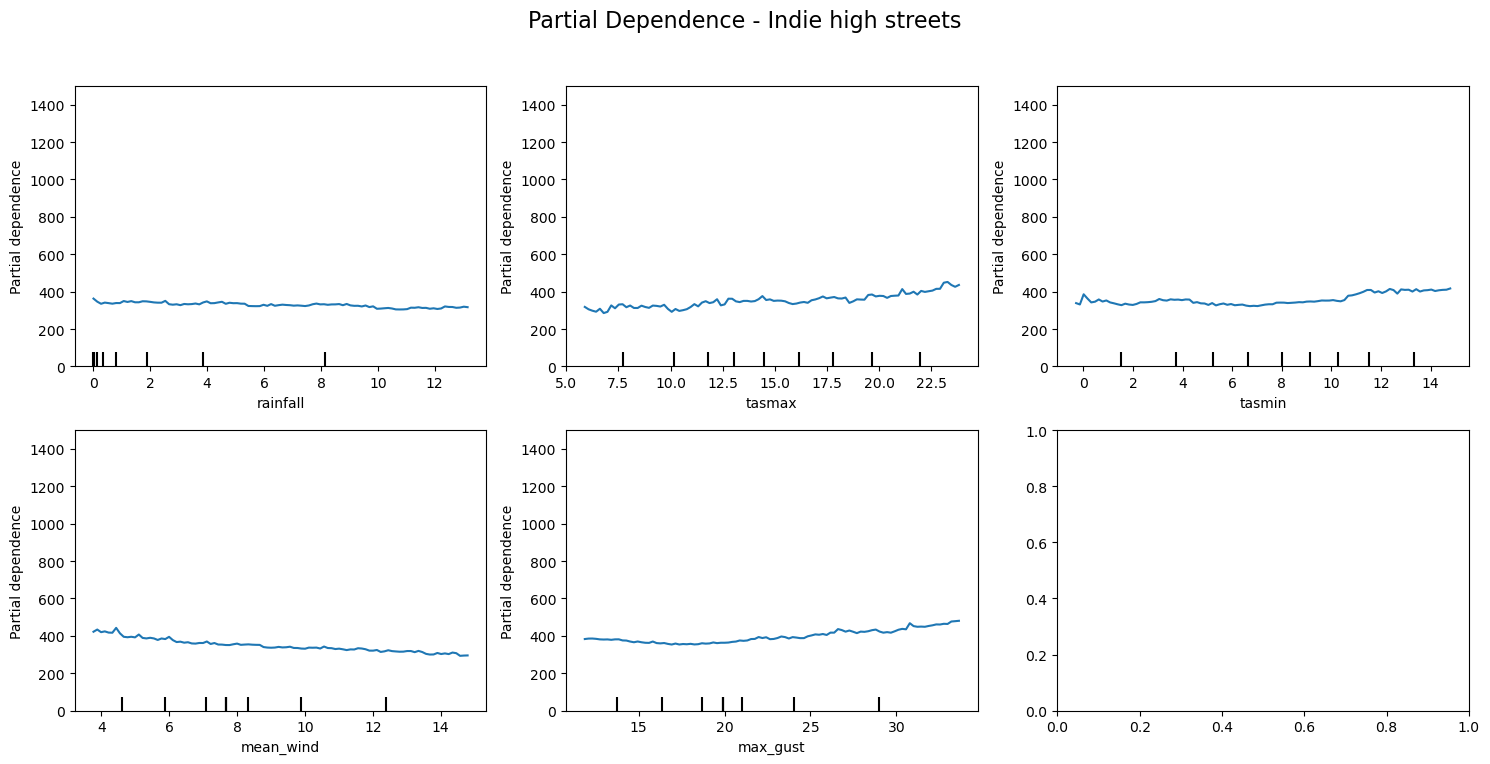

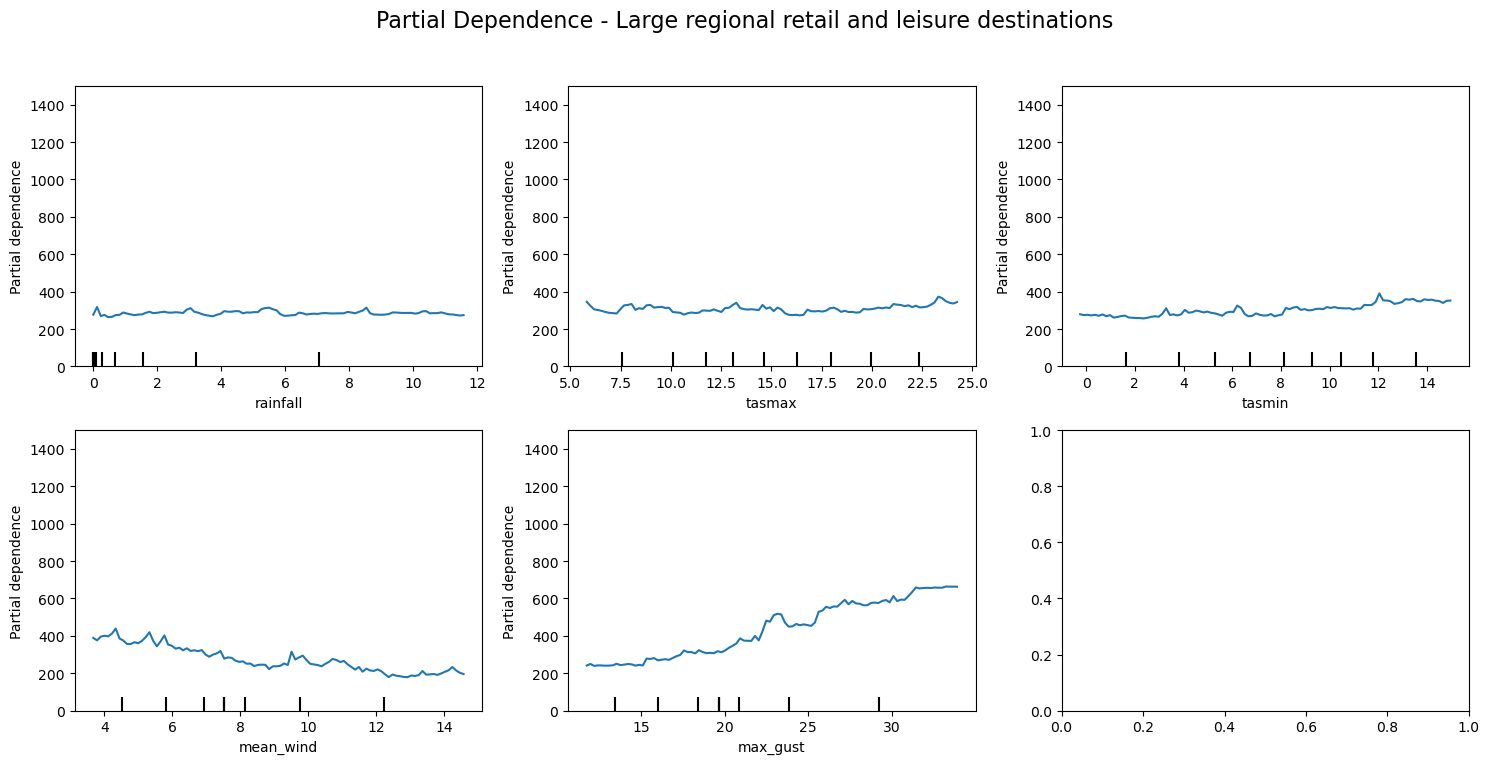

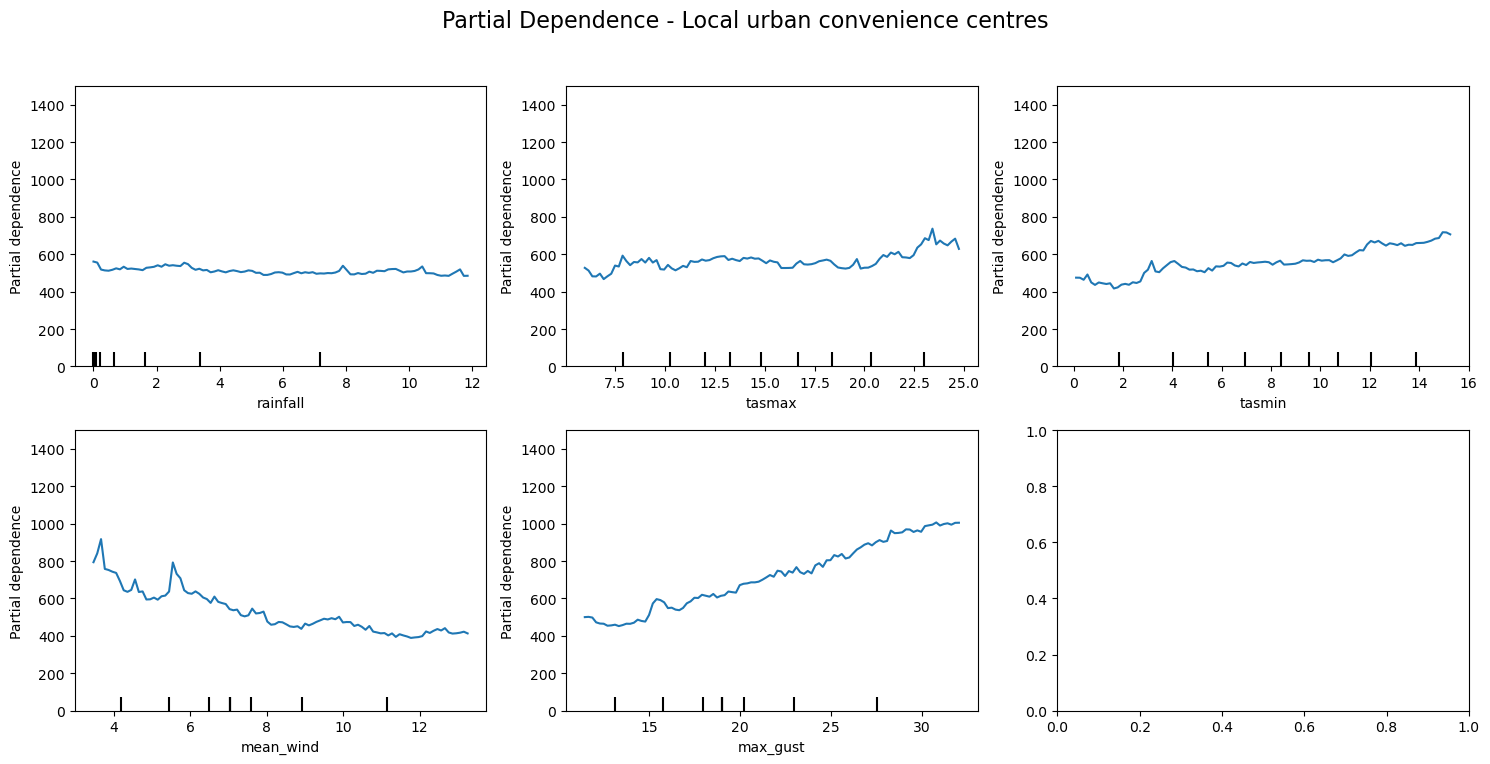

KeyboardInterrupt: 

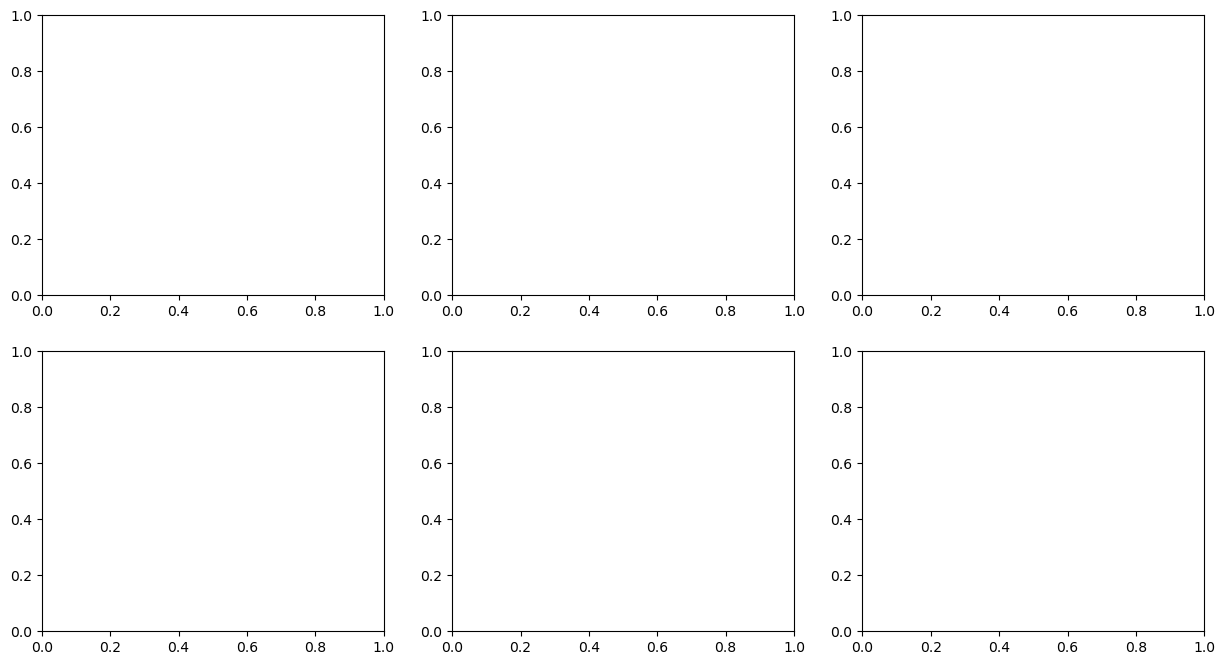

In [102]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import math

for name, group_data in df_model.groupby('groupName'):
    X = group_data[weather_vars].copy()
    y = group_data['events']
    
    # Fill missing values just in case
    X = X.fillna(X.median())
    
    model = RandomForestRegressor().fit(X, y)
    
    n_features = len(weather_vars)
    n_cols = 3
    n_rows = math.ceil(n_features / n_cols)
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    ax = np.atleast_1d(ax).flatten()

    display = PartialDependenceDisplay.from_estimator(
        model,
        X,
        features=weather_vars,
        ax=ax[:n_features]
    )

    for axis in ax[:n_features]:
        axis.set_ylim(0, 1500)
    
    plt.suptitle(f'Partial Dependence - {name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

#### Control vars

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

group_col = 'groupName'
control_vars = ['weekend', 'holiday', 'coastal', 'Residential Population (Weighted Catchment)'] + \
               [col for col in df_model.columns if col.startswith(('season_', 'Sparsity_'))]

for name, group_data in df_model.groupby(group_col):
    X = group_data[control_vars]
    y = group_data['events']
    
    if len(X) > 30:  # skip small groups
        model = RandomForestRegressor(random_state=42).fit(X, y)
        r2 = model.score(X, y)
        
        # Compute feature importances
        importances = pd.Series(model.feature_importances_, index=control_vars).sort_values(ascending=False)

        print(f"\n{name}: R² = {r2:.3f}")
        print("Feature Importances:")
        print(importances.round(3))


District urban service centres: R² = 0.700
Feature Importances:
Sparsity_5 - Urban Dense (London)              0.488
Residential Population (Weighted Catchment)    0.454
season_Winter                                  0.020
season_Spring                                  0.014
weekend                                        0.009
season_Summer                                  0.005
Sparsity_6 - Retail Park                       0.004
holiday                                        0.004
Sparsity_3 - Urban                             0.001
Sparsity_4 - Urban Dense                       0.001
coastal                                        0.001
Sparsity_2 - Small Urban                       0.000
dtype: float64

Indie high streets: R² = 0.756
Feature Importances:
Residential Population (Weighted Catchment)    0.653
Sparsity_5 - Urban Dense (London)              0.220
Sparsity_4 - Urban Dense                       0.029
season_Winter                                  0.027
season_Spring      

Add weather:

In [117]:
for name, group_data in df_model.groupby(group_col):
    X = group_data[control_vars + weather_vars]
    y = group_data['events']
    
    if len(X) > 30:  # skip small groups
        model = RandomForestRegressor(random_state=42).fit(X, y)
        r2 = model.score(X, y)
        
        # Compute feature importances
        importances = pd.Series(model.feature_importances_, index=control_vars + weather_vars).sort_values(ascending=False)

        print(f"\n{name}: R² = {r2:.3f}")
        print("Feature Importances:")
        print(importances.round(3))


District urban service centres: R² = 0.867
Feature Importances:
Sparsity_5 - Urban Dense (London)              0.357
Residential Population (Weighted Catchment)    0.334
mean_wind                                      0.076
max_gust                                       0.072
tasmax                                         0.041
tasmin                                         0.040
rainfall                                       0.035
season_Winter                                  0.015
season_Spring                                  0.011
weekend                                        0.008
season_Summer                                  0.003
Sparsity_6 - Retail Park                       0.003
holiday                                        0.002
Sparsity_3 - Urban                             0.001
Sparsity_4 - Urban Dense                       0.001
coastal                                        0.000
Sparsity_2 - Small Urban                       0.000
dtype: float64

Indie high streets

#### later

region,
spend per head,

rail/tube--- specifically for london

auto
tourism
leisure footprint